In [47]:
# ライブラリの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

sns.set(style='white', context='notebook', palette='deep')

In [48]:
# データの読み込み
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")

df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### データの前処理

In [49]:
df_test_id = df_test['PassengerId']
df_train = df_train[["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]]
df_test = df_test[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]]

df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [50]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [51]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
Pclass      418 non-null int64
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Fare        417 non-null float64
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 23.0+ KB


In [52]:
# Ageの欠損値を平均値で埋める
age_ave = df_train["Age"].mean()
df_train["Age"] = df_train["Age"].fillna(age_ave)
df_test["Age"] = df_test["Age"].fillna(age_ave)

# Fareの欠損値を平均値で埋める
fare_ave = df_train["Fare"].mean()
df_train["Fare"] = df_train["Fare"].fillna(age_ave)
df_test["Fare"] = df_train["Fare"].fillna(age_ave)

# Embarkedの欠損値を最頻値"S"で埋める
df_train["Embarked"] = df_train["Embarked"].fillna("S")
df_test["Embarked"] = df_test["Embarked"].fillna("S")

#### 同乗家族の有無を表す列の追加

In [53]:
# SibSpとParchの和が１以上であれば１、そうでなければ０となる列"hasFamily"を追加
df_train["FamilyNum"] = df_train["SibSp"] + df_train["Parch"]
df_train["hasFamily"] = df_train["FamilyNum"].apply(lambda x: 1 if x >= 1 else 0)
df_train = df_train.drop(labels = ["SibSp"], axis=1)
df_train = df_train.drop(labels = ["Parch"], axis=1)

df_test["FamilyNum"] = df_test["SibSp"] + df_test["Parch"]
df_test["hasFamily"] = df_test["FamilyNum"].apply(lambda x: 1 if x >= 1 else 0)
df_test = df_test.drop(labels=["SibSp"], axis=1)
df_test = df_test.drop(labels=["Parch"], axis=1)

#### カテゴリー変数の処理

In [54]:
# カテゴリー変数をダミー変数にエンコード
df_train = pd.get_dummies(df_train, columns=["Sex", "Pclass", "Embarked"])
df_test = pd.get_dummies(df_test, columns=["Sex", "Pclass", "Embarked"])

# エンコード後のデータ構造を確認するため表示
df_train.head()

,Survived,Age,Fare,FamilyNum,hasFamily,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,22.0,7.2500,1,1,0,1,0,0,1,0,0,1
1,1,38.0,71.2833,1,1,1,0,1,0,0,1,0,0
2,1,26.0,7.9250,0,0,1,0,0,0,1,0,0,1
3,1,35.0,53.1000,1,1,1,0,1,0,0,0,0,1
4,0,35.0,8.0500,0,0,0,1,0,0,1,0,0,1


In [55]:
# 特徴量とラベルに分割
Y_train = df_train["Survived"]
X_train = df_train.drop(labels=["Survived"], axis=1)
X_test = df_test

del df_train
del df_test

In [56]:
# 学習用セットと検証用セットに分割
random_seed = 1
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.5, random_state=random_seed)

### モデルの構築と予測

In [60]:
params = {
    "n_estimators" : [2, 5, 10, 15, 20, 30, 50, 75, 100, 200, 500, 1000],
    "criterion" : ["gini"],
    "min_samples_split" : [2, 3, 5, 10, 15, 20, 30],
    "max_depth" : [2, 3, 5, 10, 15, 20, 30],
    "random_state" : [1],
    "verbose" : [False],
}

# モデルの構築
model = GridSearchCV(RandomForestClassifier(), params, cv=3)
model = model.fit(X_train, Y_train)
model = model.best_estimator_

# 検証用セットを用いて評価
print(model.score(X_valid, Y_valid))

0.8026905829596412


In [61]:
# 予測
results = model.predict(X_test)
results = pd.Series(results, name="Survived")

In [62]:
# 提出データを作成
submission = pd.concat([df_test_id, results], axis=1)
submission.to_csv("submission_randomforest.csv", index=False)

### 考察

In [63]:
features = X_train.columns
importance = model.feature_importances_
indices = np.argsort(importance)

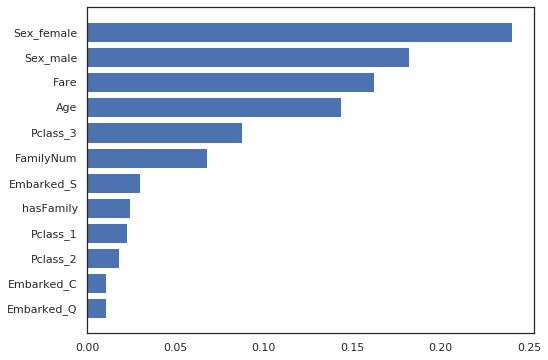

In [64]:
plt.figure(figsize= (8, 6))
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.show()